In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('cleaned_dataset.csv')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


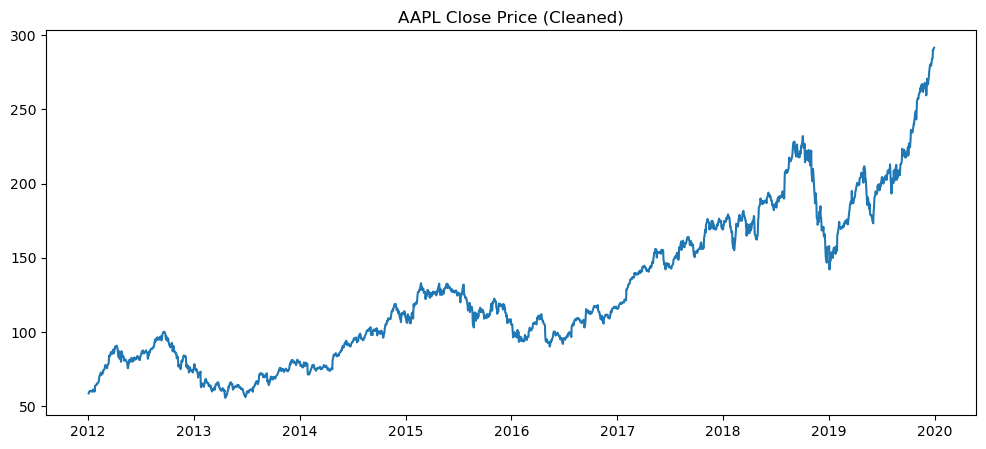

In [6]:
# Use business-day frequency and forward-fill missing values
series = df['Close'].asfreq('B').fillna(method='ffill')

plt.figure(figsize=(12,5))
plt.plot(series)
plt.title("AAPL Close Price (Cleaned)")
plt.show()

In [7]:
# Day-of-week dummy variables
exog = pd.get_dummies(series.index.dayofweek, prefix='dow')
exog.index = series.index

# Month-start feature
exog['is_month_start'] = series.index.to_series().dt.is_month_start.astype(int)

# Volume as exogenous (if exists)
if 'Volume' in df.columns:
    exog['Volume'] = df['Volume'].reindex(series.index).fillna(method='ffill')

# Convert all to float
exog = exog.astype('float64')

exog.head()

,dow_0,dow_1,dow_2,dow_3,dow_4,is_month_start,Volume
Date,,,,,,,
2012-01-03,0.0,1.0,0.0,0.0,0.0,0.0,75555200.0
2012-01-04,0.0,0.0,1.0,0.0,0.0,0.0,65005500.0
2012-01-05,0.0,0.0,0.0,1.0,0.0,0.0,67817400.0
2012-01-06,0.0,0.0,0.0,0.0,1.0,0.0,79573200.0
2012-01-09,1.0,0.0,0.0,0.0,0.0,0.0,98506100.0


In [8]:
test_days = 60
train_end = series.index[-test_days-1]

train_series = series.loc[:train_end]
test_series  = series.loc[train_end + pd.Timedelta(days=1):]

train_exog = exog.loc[train_series.index]
test_exog  = exog.loc[test_series.index]

print("Train length:", len(train_series))
print("Test length:", len(test_series))

Train length: 2025
Test length: 60


In [9]:
order_arimax = (1,1,1)

model_arimax = SARIMAX(train_series,
                       exog=train_exog,
                       order=order_arimax,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

res_arimax = model_arimax.fit(disp=False)

print(res_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2025
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4314.491
Date:                Thu, 20 Nov 2025   AIC                           8648.983
Time:                        10:24:11   BIC                           8705.101
Sample:                    01-03-2012   HQIC                          8669.577
                         - 10-07-2019                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
dow_0             -0.0527      0.000   -461.545      0.000      -0.053      -0.052
dow_1              0.0370   8.45e-05    437.127      0.000       0.037       0.037
dow_2              0.2123   2.29e-06

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

ARIMAX MSE: 1369.909813126784
ARIMAX MAE: 33.088413665174016


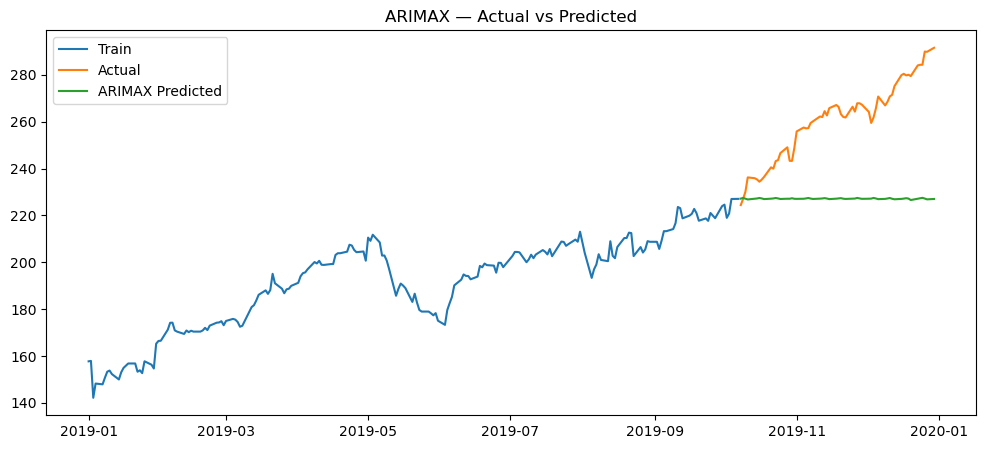

In [12]:
pred_arimax = res_arimax.get_prediction(start=test_series.index[0],
                                        end=test_series.index[-1],
                                        exog=test_exog)

pred_arimax_mean = pred_arimax.predicted_mean

mse_arimax = mean_squared_error(test_series, pred_arimax_mean)
mae_arimax = mean_absolute_error(test_series, pred_arimax_mean)

print("ARIMAX MSE:", mse_arimax)
print("ARIMAX MAE:", mae_arimax)

plt.figure(figsize=(12,5))
plt.plot(train_series[-200:], label='Train')
plt.plot(test_series, label='Actual')
plt.plot(pred_arimax_mean, label='ARIMAX Predicted')
plt.legend()
plt.title("ARIMAX — Actual vs Predicted")
plt.show()

In [13]:
order_sarimax = (1,1,1)
seasonal_order = (1,0,1,5)

model_sarimax = SARIMAX(train_series,
                         exog=train_exog,
                         order=order_sarimax,
                         seasonal_order=seasonal_order,
                         enforce_stationarity=False,
                         enforce_invertibility=False)

res_sarimax = model_sarimax.fit(disp=False)

print(res_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 2025
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood               -4305.966
Date:                           Thu, 20 Nov 2025   AIC                           8635.932
Time:                                   10:52:29   BIC                           8703.244
Sample:                               01-03-2012   HQIC                          8660.637
                                    - 10-07-2019                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
dow_0             -0.0527      0.000   -176.882      0.000      -0.053      -0.052
dow_1              0.0370      

SARIMAX MSE: 1367.0501347351426
SARIMAX MAE: 33.045185803553665


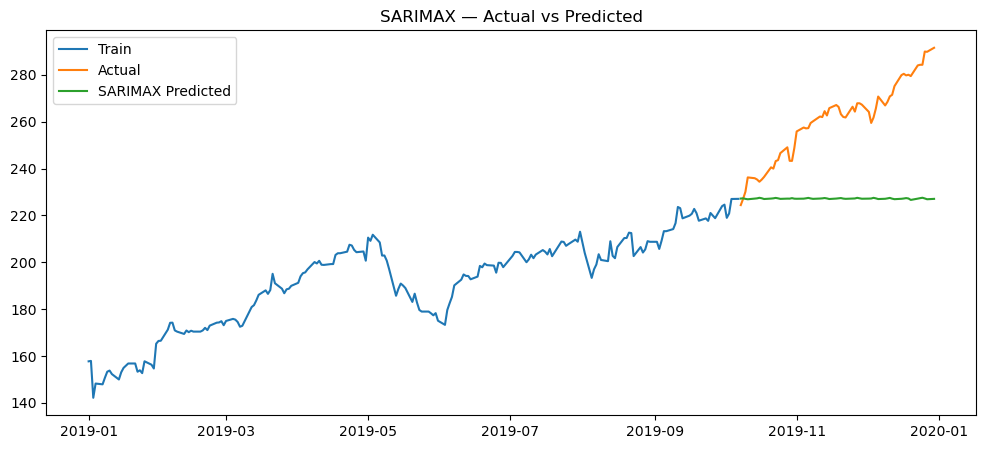

In [14]:
pred_sarimax = res_sarimax.get_prediction(start=test_series.index[0],
                                          end=test_series.index[-1],
                                          exog=test_exog)

pred_sarimax_mean = pred_sarimax.predicted_mean

mse_sarimax = mean_squared_error(test_series, pred_sarimax_mean)
mae_sarimax = mean_absolute_error(test_series, pred_sarimax_mean)

print("SARIMAX MSE:", mse_sarimax)
print("SARIMAX MAE:", mae_sarimax)

plt.figure(figsize=(12,5))
plt.plot(train_series[-200:], label='Train')
plt.plot(test_series, label='Actual')
plt.plot(pred_sarimax_mean, label='SARIMAX Predicted')
plt.legend()
plt.title("SARIMAX — Actual vs Predicted")
plt.show()

In [15]:
if mse_arimax <= mse_sarimax:
    final_model = res_arimax
    model_name = "ARIMAX"
else:
    final_model = res_sarimax
    model_name = "SARIMAX"

print("Best model selected:", model_name)

Best model selected: SARIMAX


In [16]:
horizon = 30
last_date = series.index[-1]

future_index = pd.bdate_range(start=last_date + pd.Timedelta(days=1),
                              periods=horizon)

# Build future exogenous variables
future_exog = pd.get_dummies(future_index.dayofweek, prefix='dow')
future_exog.index = future_index

future_exog['is_month_start'] = future_index.to_series().dt.is_month_start.astype(int)

if "Volume" in exog.columns:
    future_exog['Volume'] = exog['Volume'].iloc[-1]  # keep last volume as constant

# align missing columns
for c in exog.columns:
    if c not in future_exog.columns:
        future_exog[c] = 0

future_exog = future_exog[exog.columns].astype('float64')

# Forecast
forecast = final_model.get_forecast(steps=horizon, exog=future_exog)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

forecast_mean.head()

2019-10-08    227.118387
2019-10-09    227.348284
2019-10-10    226.989017
2019-10-11    226.936814
2019-10-14    227.064660
Freq: B, Name: predicted_mean, dtype: float64

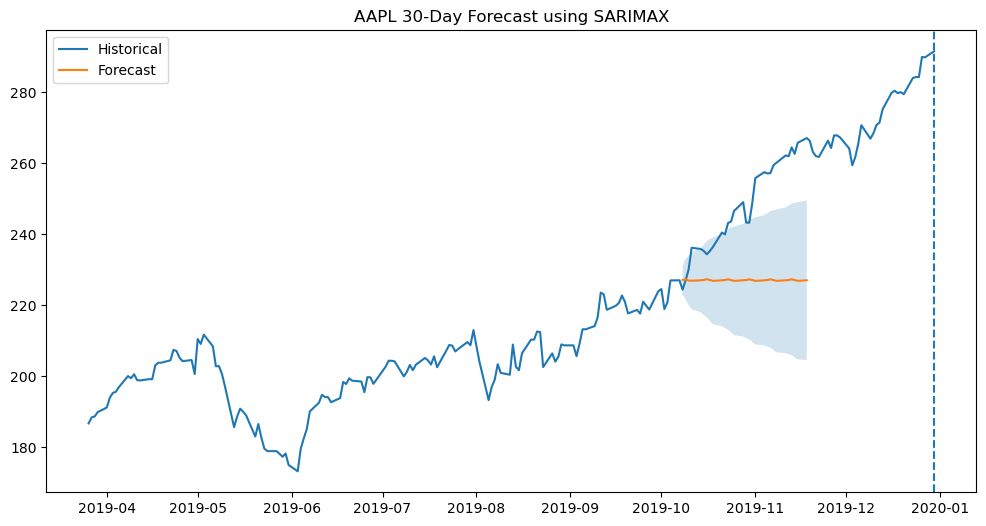

In [17]:
plt.figure(figsize=(12,6))
plt.plot(series[-200:], label='Historical')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.fill_between(forecast_mean.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 alpha=0.2)
plt.axvline(series.index[-1], linestyle='--')
plt.legend()
plt.title(f"AAPL 30-Day Forecast using {model_name}")
plt.show()